In [10]:
from algorithms.root_to_liveql import root_to_liveql
from eflint.eflint_lib import EF
from eflint.eflint_parser import get_node_to_type_map, create_graph
from eflint.save_and_open import save_dsl_to_file, open_liveql
from graph_visualizer import visualize_graph

In [11]:
ef = EF()
ef.revert(1)
ef.phrase("Fact entity Identified by String")
ef.phrase("Fact number_of_legs Identified by entity * int")
ef.phrase("Fact featherless Identified by entity")
ef.phrase("Fact biped Identified by entity Holds when (Exists number_of_legs : number_of_legs(entity, 2))")
ef.phrase("Fact intelligent Identified by entity")
ef.phrase("Fact human Identified by entity Holds when (biped(entity) && featherless(entity)) || intelligent(entity)")

{'all-disabled-transitions': [],
 'all-duties': [],
 'all-enabled-transitions': [],
 'created_facts': [],
 'errors': [],
 'inst-query-results': [],
 'new-disabled-transitions': [],
 'new-duties': [],
 'new-enabled-transitions': [],
 'new-state': 17,
 'old-state': 16,
 'output-events': [],
 'query-results': [],
 'response': 'success',
 'source_contents': [],
 'target_contents': [],
 'terminated-duties': [],
 'terminated_facts': [],
 'violations': []}

In [12]:
type_res = ef.types()
node_to_type_map = get_node_to_type_map(type_res)
node_name_to_node = create_graph(type_res)

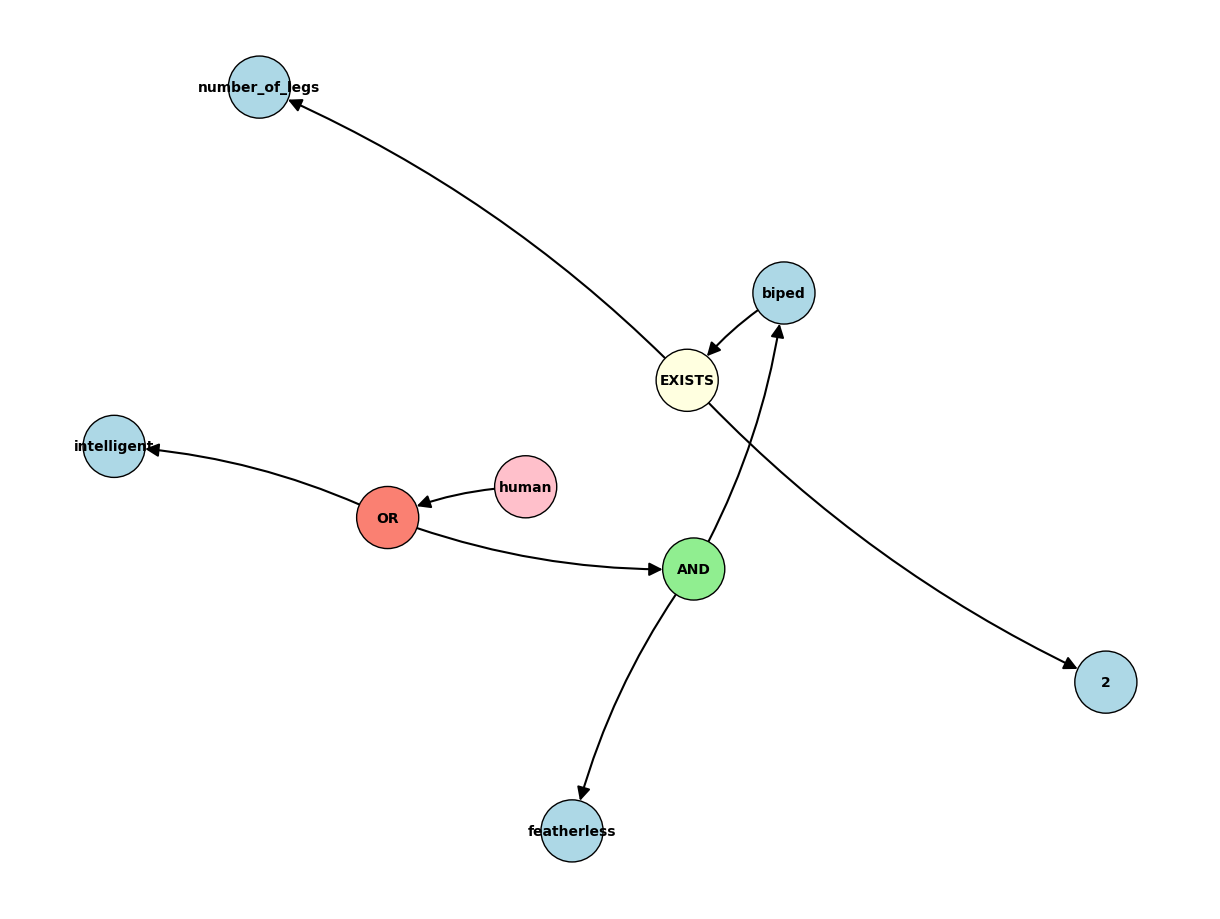

<module 'matplotlib.pyplot' from '/Users/tiemfah/Projects/eFLINTAnswers/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [13]:
visualize_graph(node_name_to_node["human"])

In [14]:
human_node = node_name_to_node["human"]
dsl_content = root_to_liveql(human_node, node_to_type_map)

In [15]:
print(dsl_content)

form humanForm {
	"Is the actor intelligent?" intelligent: bool
	"Is the actor not intelligent?" not_intelligent: bool
	if (intelligent) {
		"Property human holds" result: bool(true)
	}
	if (not_intelligent) {
		"Is the actor featherless?" featherless: bool
		"Is the actor not featherless?" not_featherless: bool
		"How many number of legs does the actor have?" number_of_legs: int
		if (number_of_legs == 2 && featherless) {
			"Property human holds" result: bool(true)
		}
		if ((number_of_legs != 2 || not_featherless) && not_intelligent) {
			"Property human does not holds" result: bool(true)
		}
	}
}


In [16]:
save_dsl_to_file(dsl_content, "human", "/Users/tiemfah/Projects/LiveQL/bin/nl/cwi/swat/liveql/examples/eflint.ql")
open_liveql()

DSL saved to /Users/tiemfah/Projects/LiveQL/bin/nl/cwi/swat/liveql/examples/eflint.ql
+(0, answerable("Is the actor intelligent?", intelligent, boolean))
+(0, answerable("Is the actor not intelligent?", not_intelligent, boolean))
+(0, ifThen(intelligent, [computed("Property human holds", result, boolean)]))
+(0, ifThen(not_intelligent, [answerable("Is the actor featherless?", featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean); answerable("Is the actor not featherless?", not_featherless, boolean)]))


2025-05-27 22:48:29.785 java[35678:1623097] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit
